In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
from torchvision.models import vgg19
from torchvision.datasets import ImageFolder
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [3]:
# Directories for dataset
data_dir = 'C:/Users/ahosain/PetImages'  s
output_dir_class1 = 'C:/Users/ahosain/SRGAN_2/Cat'
output_dir_class2 = 'C:/Users/ahosain/SRGAN_2/Dog'
os.makedirs(output_dir_class1, exist_ok=True)
os.makedirs(output_dir_class2, exist_ok=True)


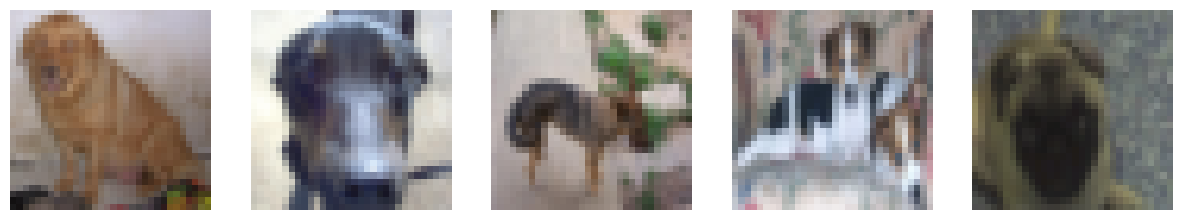

In [8]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Target output size
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to range [-1, 1]
])

# Low-resolution transformation for training
low_res_transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Downscale to 32x32
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Dataset loading
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None, low_res_transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.low_res_transform = low_res_transform
        self.classes = os.listdir(root_dir)
        self.file_paths = [(os.path.join(root_dir, cls, fname), cls) for cls in self.classes 
                           for fname in os.listdir(os.path.join(root_dir, cls))]

    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        img_path, label = self.file_paths[idx]
        
        try:
            image = Image.open(img_path).convert('RGB')
        except (UnidentifiedImageError, IOError):
            
            return self.__getitem__((idx + 1) % len(self))
        
        if self.transform:
            hr_image = self.transform(image)
        if self.low_res_transform:
            lr_image = self.low_res_transform(image)
            
        return lr_image, hr_image, label


dataset = CustomDataset(root_dir=data_dir, transform=transform, low_res_transform=low_res_transform)
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Display downscaled images
low_res_examples, _, _ = next(iter(test_loader))
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    img = low_res_examples[i].permute(1, 2, 0).cpu().numpy()
    img = (img * 0.5 + 0.5) * 255  # Denormalize
    axes[i].imshow(img.astype(np.uint8))
    axes[i].axis('off')
plt.show()

In [9]:
# Define SRGAN model with Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels)
        )
        
    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, num_residual_blocks=16):
        super(Generator, self).__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),
            nn.PReLU()
        )
        self.residuals = nn.Sequential(*[ResidualBlock(64) for _ in range(num_residual_blocks)])
        self.upsample = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=3, padding=1),
            nn.PixelShuffle(2),
            nn.PReLU(),
            nn.Conv2d(64, 256, kernel_size=3, padding=1),
            nn.PixelShuffle(2),
            nn.PReLU()
        )
        self.final = nn.Conv2d(64, 3, kernel_size=9, padding=4)
        
    def forward(self, x):
        x = self.initial(x)
        residual = self.residuals(x)
        x = self.upsample(residual)
        return torch.tanh(self.final(x))

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(256 * 16 * 16, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.conv(x)


In [10]:
# Instantiate models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [11]:
# Training loop
num_epochs = 150
for epoch in range(num_epochs):
    for lr_imgs, hr_imgs, labels in tqdm(train_loader):
        lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
        
        # Train discriminator
        optimizer_D.zero_grad()
        real_output = discriminator(hr_imgs)
        real_loss = criterion(real_output, torch.ones_like(real_output, device=device))
        
        fake_imgs = generator(lr_imgs).detach()
        fake_output = discriminator(fake_imgs)
        fake_loss = criterion(fake_output, torch.zeros_like(fake_output, device=device))
        
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()
        
        # Train generator
        optimizer_G.zero_grad()
        fake_imgs = generator(lr_imgs)
        fake_output = discriminator(fake_imgs)
        g_loss = criterion(fake_output, torch.ones_like(fake_output, device=device))
        
        g_loss.backward()
        optimizer_G.step()
        
    print(f"Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:13<00:00, 14.84it/s]


Epoch [1/150], d_loss: 1.420837640762329, g_loss: 1.7829550504684448


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:11<00:00, 15.22it/s]


Epoch [2/150], d_loss: 1.6693806648254395, g_loss: 1.5266320705413818


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:16<00:00, 14.36it/s]


Epoch [3/150], d_loss: 1.3829216957092285, g_loss: 1.1433264017105103


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:13<00:00, 14.90it/s]


Epoch [4/150], d_loss: 1.2921574115753174, g_loss: 0.9447426199913025


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:11<00:00, 15.33it/s]


Epoch [5/150], d_loss: 1.4915916919708252, g_loss: 1.1990991830825806


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:11<00:00, 15.28it/s]


Epoch [6/150], d_loss: 1.5238590240478516, g_loss: 1.53427255153656


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:15<00:00, 14.46it/s]


Epoch [7/150], d_loss: 1.1619937419891357, g_loss: 1.4040203094482422


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:14<00:00, 14.63it/s]


Epoch [8/150], d_loss: 1.509181022644043, g_loss: 1.1822980642318726


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:09<00:00, 15.84it/s]


Epoch [9/150], d_loss: 1.3103015422821045, g_loss: 1.612874984741211


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:13<00:00, 14.87it/s]


Epoch [10/150], d_loss: 1.092801570892334, g_loss: 1.3803585767745972


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:15<00:00, 14.58it/s]


Epoch [11/150], d_loss: 1.514085054397583, g_loss: 1.1893466711044312


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:16<00:00, 14.27it/s]


Epoch [12/150], d_loss: 2.1076319217681885, g_loss: 2.498385190963745


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:15<00:00, 14.56it/s]


Epoch [13/150], d_loss: 1.3931547403335571, g_loss: 1.253372073173523


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:13<00:00, 14.88it/s]


Epoch [14/150], d_loss: 1.404775619506836, g_loss: 1.2044317722320557


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:12<00:00, 15.00it/s]


Epoch [15/150], d_loss: 1.275300145149231, g_loss: 1.2030662298202515


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:16<00:00, 14.37it/s]


Epoch [16/150], d_loss: 1.2883012294769287, g_loss: 1.7739574909210205


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:15<00:00, 14.52it/s]


Epoch [17/150], d_loss: 1.320324420928955, g_loss: 1.325290560722351


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:16<00:00, 14.37it/s]


Epoch [18/150], d_loss: 1.2424159049987793, g_loss: 1.1665979623794556


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:16<00:00, 14.38it/s]


Epoch [19/150], d_loss: 1.0505504608154297, g_loss: 1.5817283391952515


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:16<00:00, 14.39it/s]


Epoch [20/150], d_loss: 1.1424143314361572, g_loss: 1.515825629234314


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:18<00:00, 13.88it/s]


Epoch [21/150], d_loss: 1.489501953125, g_loss: 1.062522053718567


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:15<00:00, 14.57it/s]


Epoch [22/150], d_loss: 1.5841739177703857, g_loss: 2.446885347366333


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:16<00:00, 14.33it/s]


Epoch [23/150], d_loss: 1.504189133644104, g_loss: 1.1665366888046265


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:14<00:00, 14.63it/s]


Epoch [24/150], d_loss: 1.1970899105072021, g_loss: 1.2187265157699585


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:16<00:00, 14.31it/s]


Epoch [25/150], d_loss: 1.519247055053711, g_loss: 1.1273020505905151


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:14<00:00, 14.68it/s]


Epoch [26/150], d_loss: 1.1455442905426025, g_loss: 0.9599453210830688


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:18<00:00, 13.91it/s]


Epoch [27/150], d_loss: 1.1061272621154785, g_loss: 1.4759982824325562


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:15<00:00, 14.47it/s]


Epoch [28/150], d_loss: 1.0941357612609863, g_loss: 1.6285072565078735


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:15<00:00, 14.54it/s]


Epoch [29/150], d_loss: 1.1777187585830688, g_loss: 1.179268479347229


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:14<00:00, 14.71it/s]


Epoch [30/150], d_loss: 1.3082036972045898, g_loss: 0.8255041241645813


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:16<00:00, 14.27it/s]


Epoch [31/150], d_loss: 1.4496735334396362, g_loss: 0.8154021501541138


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:18<00:00, 13.94it/s]


Epoch [32/150], d_loss: 1.4878963232040405, g_loss: 0.6928750276565552


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:13<00:00, 14.82it/s]


Epoch [33/150], d_loss: 0.9824909567832947, g_loss: 1.558717131614685


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:13<00:00, 14.97it/s]


Epoch [34/150], d_loss: 1.0642619132995605, g_loss: 1.107160210609436


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:13<00:00, 14.93it/s]


Epoch [35/150], d_loss: 1.5051571130752563, g_loss: 1.582314372062683


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:12<00:00, 15.03it/s]


Epoch [36/150], d_loss: 0.9135379791259766, g_loss: 1.7407989501953125


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:13<00:00, 14.94it/s]


Epoch [37/150], d_loss: 1.2928504943847656, g_loss: 1.2199910879135132


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:10<00:00, 15.46it/s]


Epoch [38/150], d_loss: 1.2909650802612305, g_loss: 1.0722306966781616


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:12<00:00, 15.17it/s]


Epoch [39/150], d_loss: 1.3323285579681396, g_loss: 1.6387017965316772


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:15<00:00, 14.42it/s]


Epoch [40/150], d_loss: 1.1599702835083008, g_loss: 2.5607948303222656


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:13<00:00, 14.79it/s]


Epoch [41/150], d_loss: 1.3753156661987305, g_loss: 0.9882261157035828


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:13<00:00, 14.80it/s]


Epoch [42/150], d_loss: 0.9745384454727173, g_loss: 1.7653191089630127


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:09<00:00, 15.79it/s]


Epoch [43/150], d_loss: 1.2945514917373657, g_loss: 1.3909387588500977


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:14<00:00, 14.66it/s]


Epoch [44/150], d_loss: 1.1653567552566528, g_loss: 1.7162811756134033


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:09<00:00, 15.66it/s]


Epoch [45/150], d_loss: 1.1335268020629883, g_loss: 1.6587936878204346


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:16<00:00, 14.27it/s]


Epoch [46/150], d_loss: 1.2507284879684448, g_loss: 1.7979387044906616


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:12<00:00, 15.00it/s]


Epoch [47/150], d_loss: 1.1456151008605957, g_loss: 1.61648428440094


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:11<00:00, 15.32it/s]


Epoch [48/150], d_loss: 0.8387812376022339, g_loss: 2.3748013973236084


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:13<00:00, 14.97it/s]


Epoch [49/150], d_loss: 1.1223934888839722, g_loss: 1.0467153787612915


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:17<00:00, 14.19it/s]


Epoch [50/150], d_loss: 1.11564040184021, g_loss: 2.1343839168548584


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:16<00:00, 14.26it/s]


Epoch [51/150], d_loss: 1.4227616786956787, g_loss: 1.228225588798523


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:14<00:00, 14.62it/s]


Epoch [52/150], d_loss: 1.4874294996261597, g_loss: 0.6413664817810059


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:10<00:00, 15.57it/s]


Epoch [53/150], d_loss: 1.2130934000015259, g_loss: 1.4252822399139404


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:15<00:00, 14.49it/s]


Epoch [54/150], d_loss: 1.0382030010223389, g_loss: 2.3194007873535156


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:12<00:00, 15.05it/s]


Epoch [55/150], d_loss: 1.3876572847366333, g_loss: 2.168395519256592


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:21<00:00, 13.37it/s]


Epoch [56/150], d_loss: 0.9212223291397095, g_loss: 1.2891114950180054


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:14<00:00, 14.64it/s]


Epoch [57/150], d_loss: 1.54573392868042, g_loss: 1.9654159545898438


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:12<00:00, 15.17it/s]


Epoch [58/150], d_loss: 1.1819356679916382, g_loss: 1.52840256690979


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:15<00:00, 14.48it/s]


Epoch [59/150], d_loss: 0.9368113875389099, g_loss: 2.5425310134887695


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:14<00:00, 14.74it/s]


Epoch [60/150], d_loss: 1.3232390880584717, g_loss: 1.0194178819656372


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:18<00:00, 13.96it/s]


Epoch [61/150], d_loss: 0.8980848789215088, g_loss: 1.1870813369750977


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:12<00:00, 15.17it/s]


Epoch [62/150], d_loss: 1.03983473777771, g_loss: 1.0374752283096313


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:12<00:00, 15.08it/s]


Epoch [63/150], d_loss: 1.0020486116409302, g_loss: 2.1117007732391357


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:11<00:00, 15.33it/s]


Epoch [64/150], d_loss: 1.0490999221801758, g_loss: 1.2448080778121948


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:13<00:00, 14.86it/s]


Epoch [65/150], d_loss: 1.4352028369903564, g_loss: 1.0219029188156128


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:15<00:00, 14.51it/s]


Epoch [66/150], d_loss: 1.0516607761383057, g_loss: 2.301542282104492


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:12<00:00, 15.05it/s]


Epoch [67/150], d_loss: 1.453954815864563, g_loss: 2.418748617172241


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:14<00:00, 14.78it/s]


Epoch [68/150], d_loss: 0.652928352355957, g_loss: 2.1209487915039062


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:13<00:00, 14.81it/s]


Epoch [69/150], d_loss: 1.2060182094573975, g_loss: 0.977390468120575


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:17<00:00, 14.10it/s]


Epoch [70/150], d_loss: 0.8376765251159668, g_loss: 1.30916428565979


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:21<00:00, 13.48it/s]


Epoch [71/150], d_loss: 0.9201004505157471, g_loss: 0.8484215140342712


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:15<00:00, 14.55it/s]


Epoch [72/150], d_loss: 1.4343338012695312, g_loss: 1.423506259918213


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:15<00:00, 14.45it/s]


Epoch [73/150], d_loss: 0.5771570205688477, g_loss: 2.550433397293091


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:11<00:00, 15.34it/s]


Epoch [74/150], d_loss: 1.370401382446289, g_loss: 1.3977502584457397


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:16<00:00, 14.37it/s]


Epoch [75/150], d_loss: 0.7595425844192505, g_loss: 2.724884271621704


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:17<00:00, 14.10it/s]


Epoch [76/150], d_loss: 1.1843554973602295, g_loss: 0.8022257685661316


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:12<00:00, 15.00it/s]


Epoch [77/150], d_loss: 1.0180976390838623, g_loss: 0.9843600392341614


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:13<00:00, 14.85it/s]


Epoch [78/150], d_loss: 1.4574223756790161, g_loss: 1.0804013013839722


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:14<00:00, 14.70it/s]


Epoch [79/150], d_loss: 1.4801522493362427, g_loss: 1.0813076496124268


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:16<00:00, 14.35it/s]


Epoch [80/150], d_loss: 0.6077467203140259, g_loss: 2.3042848110198975


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:16<00:00, 14.28it/s]


Epoch [81/150], d_loss: 0.4745820462703705, g_loss: 2.4892044067382812


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:11<00:00, 15.31it/s]


Epoch [82/150], d_loss: 1.0759623050689697, g_loss: 1.424803376197815


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:12<00:00, 14.99it/s]


Epoch [83/150], d_loss: 1.032505750656128, g_loss: 2.9810004234313965


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:13<00:00, 14.92it/s]


Epoch [84/150], d_loss: 0.6508826017379761, g_loss: 2.2195000648498535


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:14<00:00, 14.62it/s]


Epoch [85/150], d_loss: 0.8456043004989624, g_loss: 1.7281278371810913


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:12<00:00, 15.18it/s]


Epoch [86/150], d_loss: 1.3161613941192627, g_loss: 1.3204759359359741


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:12<00:00, 14.99it/s]


Epoch [87/150], d_loss: 0.9665094614028931, g_loss: 1.6317013502120972


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:14<00:00, 14.59it/s]


Epoch [88/150], d_loss: 0.5236263871192932, g_loss: 3.2899131774902344


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:13<00:00, 14.93it/s]


Epoch [89/150], d_loss: 0.6321698427200317, g_loss: 2.7084479331970215


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:16<00:00, 14.37it/s]


Epoch [90/150], d_loss: 0.7989762425422668, g_loss: 2.6004045009613037


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:15<00:00, 14.52it/s]


Epoch [91/150], d_loss: 0.7662022113800049, g_loss: 1.8664482831954956


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:14<00:00, 14.74it/s]


Epoch [92/150], d_loss: 0.7429036498069763, g_loss: 1.513930320739746


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:10<00:00, 15.43it/s]


Epoch [93/150], d_loss: 0.5843871235847473, g_loss: 3.0413122177124023


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:16<00:00, 14.22it/s]


Epoch [94/150], d_loss: 0.9029722809791565, g_loss: 1.2409871816635132


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:14<00:00, 14.75it/s]


Epoch [95/150], d_loss: 0.6366677284240723, g_loss: 2.063462018966675


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:13<00:00, 14.94it/s]


Epoch [96/150], d_loss: 0.8512879610061646, g_loss: 0.9074609875679016


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:13<00:00, 14.81it/s]


Epoch [97/150], d_loss: 0.8238211870193481, g_loss: 1.8727591037750244


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:16<00:00, 14.39it/s]


Epoch [98/150], d_loss: 1.5454661846160889, g_loss: 0.5064647197723389


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:16<00:00, 14.22it/s]


Epoch [99/150], d_loss: 0.7037116289138794, g_loss: 2.374443769454956


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:17<00:00, 14.17it/s]


Epoch [100/150], d_loss: 1.6765766143798828, g_loss: 0.4620683789253235


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:11<00:00, 15.23it/s]


Epoch [101/150], d_loss: 0.6252383589744568, g_loss: 2.8147408962249756


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:11<00:00, 15.24it/s]


Epoch [102/150], d_loss: 1.0235241651535034, g_loss: 2.682934284210205


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:11<00:00, 15.26it/s]


Epoch [103/150], d_loss: 0.7328814268112183, g_loss: 2.307467222213745


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:14<00:00, 14.63it/s]


Epoch [104/150], d_loss: 0.7517468929290771, g_loss: 2.4156832695007324


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:15<00:00, 14.52it/s]


Epoch [105/150], d_loss: 0.8547884821891785, g_loss: 2.5937719345092773


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:13<00:00, 14.96it/s]


Epoch [106/150], d_loss: 0.8297920227050781, g_loss: 1.8464946746826172


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:12<00:00, 15.14it/s]


Epoch [107/150], d_loss: 1.143463373184204, g_loss: 1.9207195043563843


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:16<00:00, 14.37it/s]


Epoch [108/150], d_loss: 1.6422288417816162, g_loss: 0.7883835434913635


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:18<00:00, 13.99it/s]


Epoch [109/150], d_loss: 0.5402582287788391, g_loss: 2.2922186851501465


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:15<00:00, 14.42it/s]


Epoch [110/150], d_loss: 0.9450758695602417, g_loss: 1.7784864902496338


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:14<00:00, 14.78it/s]


Epoch [111/150], d_loss: 1.3006653785705566, g_loss: 2.8724536895751953


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:13<00:00, 14.82it/s]


Epoch [112/150], d_loss: 0.6785231828689575, g_loss: 2.2924411296844482


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:14<00:00, 14.78it/s]


Epoch [113/150], d_loss: 0.6450921297073364, g_loss: 1.545019507408142


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:18<00:00, 13.86it/s]


Epoch [114/150], d_loss: 1.085798978805542, g_loss: 1.5145219564437866


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:15<00:00, 14.46it/s]


Epoch [115/150], d_loss: 0.9306910037994385, g_loss: 4.145047664642334


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:08<00:00, 15.98it/s]


Epoch [116/150], d_loss: 1.151468276977539, g_loss: 1.009001612663269


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:17<00:00, 14.07it/s]


Epoch [117/150], d_loss: 0.8833614587783813, g_loss: 2.1466598510742188


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:11<00:00, 15.37it/s]


Epoch [118/150], d_loss: 0.7480450868606567, g_loss: 2.270545721054077


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:16<00:00, 14.37it/s]


Epoch [119/150], d_loss: 0.8414175510406494, g_loss: 1.8830646276474


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:11<00:00, 15.22it/s]


Epoch [120/150], d_loss: 0.8711409568786621, g_loss: 3.2917633056640625


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:16<00:00, 14.39it/s]


Epoch [121/150], d_loss: 0.8972556591033936, g_loss: 1.288291573524475


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:10<00:00, 15.58it/s]


Epoch [122/150], d_loss: 0.7402245998382568, g_loss: 2.354428768157959


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:15<00:00, 14.50it/s]


Epoch [123/150], d_loss: 1.5959492921829224, g_loss: 3.1734862327575684


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:16<00:00, 14.39it/s]


Epoch [124/150], d_loss: 0.8609790802001953, g_loss: 2.738178014755249


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:11<00:00, 15.30it/s]


Epoch [125/150], d_loss: 0.9680793285369873, g_loss: 1.6556886434555054


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:12<00:00, 15.02it/s]


Epoch [126/150], d_loss: 2.4466047286987305, g_loss: 0.7379083037376404


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:16<00:00, 14.24it/s]


Epoch [127/150], d_loss: 0.6098766326904297, g_loss: 3.2644195556640625


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:12<00:00, 15.16it/s]


Epoch [128/150], d_loss: 0.5509278178215027, g_loss: 2.0712687969207764


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:18<00:00, 13.94it/s]


Epoch [129/150], d_loss: 0.5838444232940674, g_loss: 2.3818931579589844


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:11<00:00, 15.21it/s]


Epoch [130/150], d_loss: 1.0334535837173462, g_loss: 1.2806921005249023


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:14<00:00, 14.60it/s]


Epoch [131/150], d_loss: 0.5191655158996582, g_loss: 2.4953789710998535


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:12<00:00, 15.19it/s]


Epoch [132/150], d_loss: 0.7265304923057556, g_loss: 2.246070146560669


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:18<00:00, 13.91it/s]


Epoch [133/150], d_loss: 1.1679704189300537, g_loss: 1.9674056768417358


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:13<00:00, 14.97it/s]


Epoch [134/150], d_loss: 1.3141406774520874, g_loss: 2.4022655487060547


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:12<00:00, 15.01it/s]


Epoch [135/150], d_loss: 1.4378864765167236, g_loss: 2.999462366104126


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:14<00:00, 14.59it/s]


Epoch [136/150], d_loss: 0.9974208474159241, g_loss: 1.5587042570114136


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:13<00:00, 14.94it/s]


Epoch [137/150], d_loss: 0.8926308751106262, g_loss: 1.7193412780761719


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:16<00:00, 14.24it/s]


Epoch [138/150], d_loss: 0.49662601947784424, g_loss: 3.025801420211792


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:15<00:00, 14.44it/s]


Epoch [139/150], d_loss: 0.7036023139953613, g_loss: 2.4750401973724365


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:11<00:00, 15.20it/s]


Epoch [140/150], d_loss: 1.2720152139663696, g_loss: 2.3006210327148438


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:10<00:00, 15.45it/s]


Epoch [141/150], d_loss: 0.970309853553772, g_loss: 2.6314029693603516


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:13<00:00, 14.95it/s]


Epoch [142/150], d_loss: 0.987011194229126, g_loss: 2.233379364013672


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:15<00:00, 14.45it/s]


Epoch [143/150], d_loss: 0.7893893718719482, g_loss: 1.7587193250656128


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:15<00:00, 14.50it/s]


Epoch [144/150], d_loss: 1.2776761054992676, g_loss: 1.4854023456573486


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:10<00:00, 15.47it/s]


Epoch [145/150], d_loss: 0.5945486426353455, g_loss: 3.572544813156128


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:14<00:00, 14.72it/s]


Epoch [146/150], d_loss: 0.9986315369606018, g_loss: 1.9525845050811768


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:10<00:00, 15.50it/s]


Epoch [147/150], d_loss: 1.4330023527145386, g_loss: 3.4487011432647705


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:14<00:00, 14.72it/s]


Epoch [148/150], d_loss: 0.8494217395782471, g_loss: 2.728360891342163


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:13<00:00, 14.83it/s]


Epoch [149/150], d_loss: 0.8482388257980347, g_loss: 1.4840281009674072


100%|██████████████████████████████████████████████████████████████████████████████| 1094/1094 [01:14<00:00, 14.63it/s]

Epoch [150/150], d_loss: 0.5991616249084473, g_loss: 2.383004665374756


In [22]:
# Save generated images 
generator.eval()
with torch.no_grad():
    
    all_loaders = [(train_loader, "train"), (test_loader, "test")]
    counter = 0  
    
    for loader, dataset_type in all_loaders:
        for lr_imgs, hr_imgs, labels in loader:
            lr_imgs = lr_imgs.to(device)
            gen_imgs = generator(lr_imgs)
            
            # Save images in separate folders based on class
            for i, img in enumerate(gen_imgs):
                label = labels[i]
                output_folder = output_dir_class1 if label == dataset.classes[0] else output_dir_class2
                save_image(img, os.path.join(output_folder, f"{dataset_type}_gen_img_{counter}.png"))
                counter += 1  


Generated Samples from Class 1:


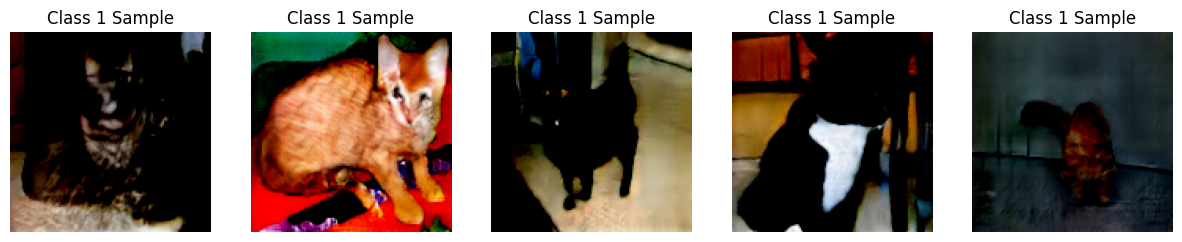

Generated Samples from Class 2:


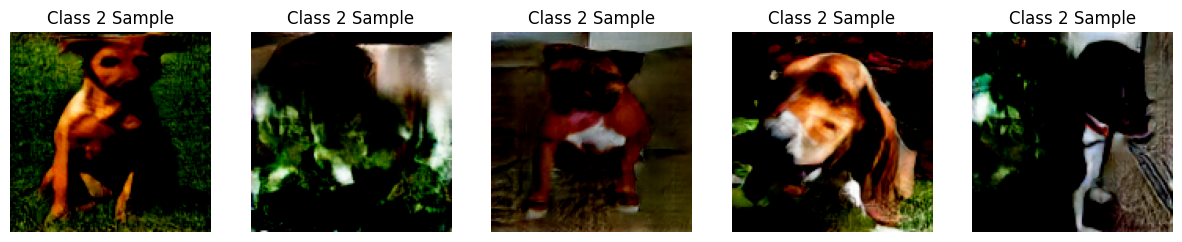

In [23]:
import matplotlib.pyplot as plt
from torchvision.io import read_image
import torchvision.transforms as T
import random

# Directories for saved generated images
output_dir_class1 = 'C:/Users/ahosain/SRGAN_2/Cat'
output_dir_class2 = 'C:/Users/ahosain/SRGAN_2/Dog'

# Function to display images from saved folders
def show_saved_samples(output_dir, num_samples=5, class_name="Class"):
    image_files = os.listdir(output_dir)
    selected_files = random.sample(image_files, num_samples)  

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i, file in enumerate(selected_files):
        img_path = os.path.join(output_dir, file)
        img = read_image(img_path)  
        img = T.ToPILImage()(img)  

        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"{class_name} Sample")

    plt.show()

# Show samples from both classes
print("Generated Samples from Class 1:")
show_saved_samples(output_dir_class1, num_samples=5, class_name="Class 1")

print("Generated Samples from Class 2:")
show_saved_samples(output_dir_class2, num_samples=5, class_name="Class 2")